# 2. Исследовать, для каких задач подходит / не подходит

В данном разделе рассматриваются случаи, когда метод кластеризации k-means даёт неоднозначные результаты. Подходящие задачи были рассмотрены в разделе 1.

# 2.1. Малое количество объектов и кластеров

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Entered by the user

In [89]:
#Малое число объёктов и кластеров
k = 3  # Clusters number (centers number)
n_points = 10 # Data quantity
centroids_residual = 0.001 # Residual for checking centroids
#centroids = initialize_centroids(points, k)  # min_max_mid initial
#centroids = initialize_centroids_random(points, k)  # random initial

# Default parameters

In [90]:
exit_condition = False

#for plots of clusters distribution
xlim_min = -0.2
xlim_max = 1.2
ylim_min = -0.2
ylim_max = 1.2

# Data initialization

Вход:

$\{x_{1},...,x_{m}\}\subseteq R^n$

In [91]:
points = np.random.rand(n_points,2)
#points = np.array([[1,2], [2,3], [3,3], [4,4], [7,5], [8,6], [9,7], [8,8], [9,9], [10,10]])
#points = [[int(i) for j in range(2)] for i in range(10)]

In [92]:
#print(points)

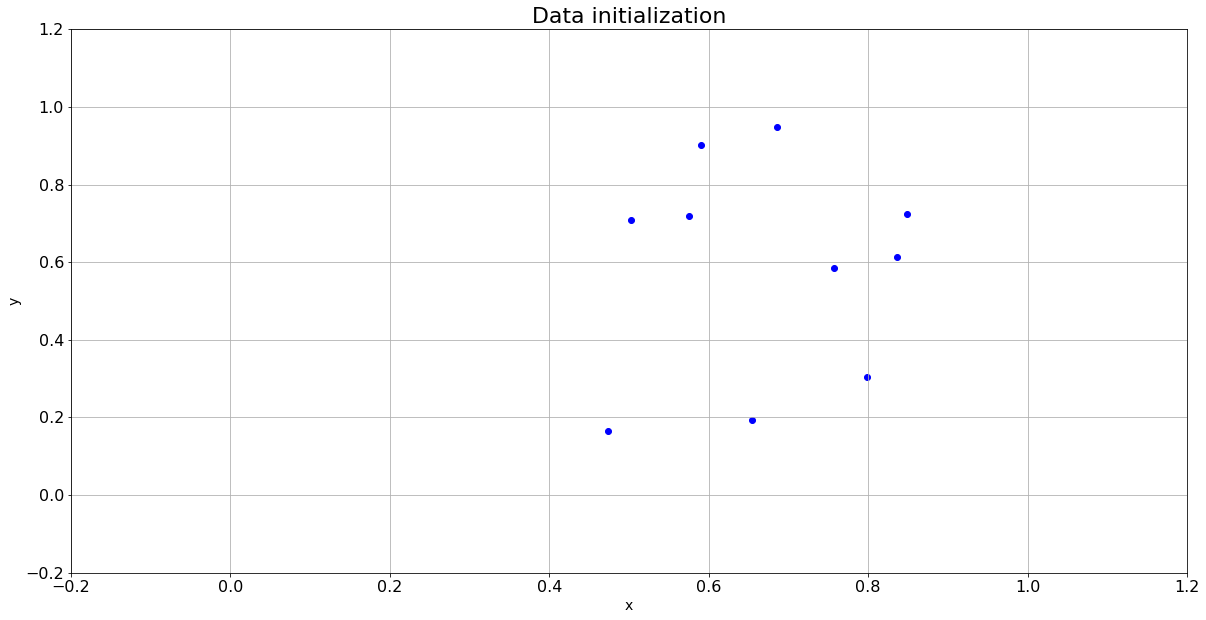

In [93]:
#plt.axes(xlim=(xlim_min, xlim_max), ylim=(ylim_min, ylim_max))
plt.figure(figsize = (20,10))
plt.title('Data initialization', fontsize = 22)
plt.xlabel('x', fontsize = 14)
plt.ylabel('y', fontsize = 14)
plt.grid(True)
plt.scatter(points[:,0], points[:,1], c = 'blue')
plt.xticks(np.linspace(xlim_min, xlim_max, 8), fontsize = 16)
plt.yticks(np.linspace(ylim_min, ylim_max, 8), fontsize = 16);

Инициализация k центров кластеров.

$\{\mu_{1},...,\mu_{k}\}\subseteq R^n$

In [94]:
def initialize_centroids(data, k):
    dist = []
    centroids = np.zeros((k, 2))
    random_n = []
    n = 0
    i = 0
    dist = np.sqrt(np.sum(data**2, axis = 1))
    if k >= 3:
        centroids[0] = data[np.argmax(dist)]
        random_n.append(np.argmax(dist))
        k -= 1
        if np.argmin(dist) not in random_n:
            centroids[1] = data[np.argmin(dist)]
            random_n.append(np.argmin(dist))
            k -= 1
            if (len(data) // 2) not in random_n:
                centroids[2] = data[len(data) // 2]
                random_n.append(len(data) // 2)
                k -= 1
                i = 3
                while k != 0:
                    n = np.random.randint(0, (len(data) - 1))
                    if n not in random_n:
                        random_n.append(n)
                        centroids[i] = data[n]
                        k -= 1
                        i += 1
                    else:
                        continue
            else:
                while k != 0:
                    n = np.random.randint(0, (len(data) - 1))
                    if n not in random_n:
                        random_n.append(n)
                        centroids[i] = data[n]
                        k -= 1
                        i += 1
                    else:
                        continue
        else:
            while k != 0:
                n = np.random.randint(0, (len(data) - 1))
                if n not in random_n:
                    random_n.append(n)
                    centroids[i] = data[n]
                    k -= 1
                    i += 1
                else:
                    continue
                
    elif k == 1:
        centroids[0] = data[np.argmax(dist)]
    elif k == 2:
        centroids[0] = data[np.argmax(dist)]
        centroids[1] = data[np.argmin(dist)]
    return centroids

In [95]:
def initialize_centroids_random(data, k):
    dist = []
    centroids = np.zeros((k, 2))
    random_n = []
    n = 0
    i = 0
    while k != 0:
        n = np.random.randint(0, (len(data) - 1))
        if n not in random_n:
            random_n.append(n)
            centroids[i] = data[n]
            k -= 1
            i += 1
        else:
            continue
    return centroids

Нахождение ближайшего центроида к каждой точке (assignment). Каждый объект приписать к тому кластеру, к центру которого он ближе

$С_{t} = \{i\mid k=argmin\parallel x_{i} - \mu_{t}\parallel^2$\}

In [96]:
def closest_centroids(points, centroids, n_points, k):
    dist = np.zeros((n_points, k))
    #print(dist)
    for i in range(n_points):
        for j in range(k):
            dist[i][j] = np.sqrt(((points[i][0] - centroids[j][0]) ** 2) + ((points[i][1] - centroids[j][1]) ** 2))    
    #print(dist)
    return np.argmin(dist, axis = 1)

Пересчет центров кластеров (update). Подсчитывается среднеарифметическое значение для каждого центра кластера. При неопределённости вида "деление на ноль" оставляем центр неизменным.

$\mu_{t} = \frac {1}{|C_{t}|}\sum_{i\in C_{t}}  x_{i}$

In [97]:
def move_centroids(points, centroids, closest_points, k):
    new_centroids = np.zeros((k, 2))   
    new_centroids = np.array([points[closest_points==i].mean(axis=0) if i in closest_points else centroids[i] for i in range(centroids.shape[0])])
    return new_centroids

Расчёт невязки. Подсчитывается разность между текущими новыми и предыдущими центроидами. Значение невязки задаётся в программе

$\mu_{cur} - \mu_{prev} < \mu_{residual}$

In [98]:
def residual_check(new_centroids, centroids, residual):
    result = True
    residual_arr = np.absolute(new_centroids - centroids)
    checking = np.zeros((residual_arr.shape[0], residual_arr.shape[1]))
    for i in range(residual_arr.shape[0]):
        for j in range(residual_arr.shape[1]):
            if residual_arr[i][j] <= residual:
                checking[i][j] = True
            else:
                checking[i][j] = False  
    #print(checking)
    for i in range(checking.shape[0]):
        for j in range(checking.shape[1]):
            if checking[i][j] == False:
                result = False
            else:
                continue
    return result

# Entered by the user

In [99]:
#centroids = initialize_centroids(points, k)  # min_max_mid initial
centroids = initialize_centroids_random(points, k)  # random initial

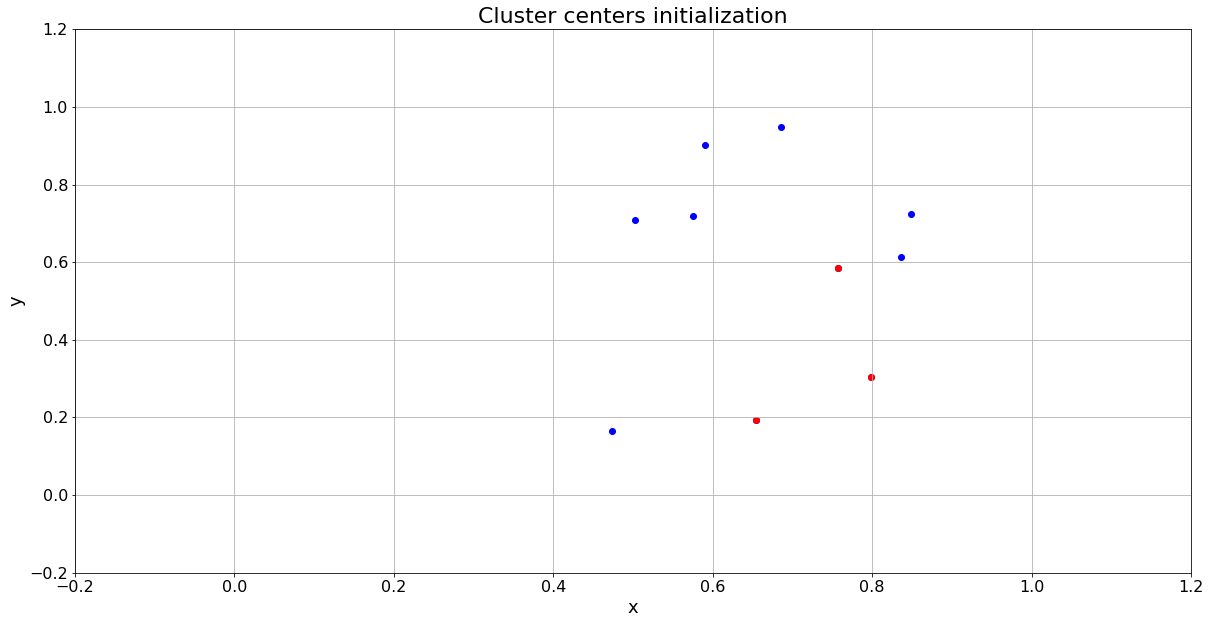

In [100]:
plt.figure(figsize = (20,10))
#plt.axes(xlim=(xlim_min, xlim_max), ylim=(ylim_min, ylim_max))
plt.title('Cluster centers initialization', fontsize = 22)
plt.xlabel('x', fontsize = 18)
plt.ylabel('y', fontsize = 18)
plt.grid(True)
plt.scatter(points[:,0], points[:,1], c = 'blue')
plt.scatter(centroids[:,0], centroids[:,1], c = 'red')
plt.xticks(np.linspace(xlim_min, xlim_max, 8), fontsize = 16)
plt.yticks(np.linspace(ylim_min, ylim_max, 8), fontsize = 16);

In [101]:
closest_points = closest_centroids(points, centroids, n_points, k)
print(closest_points)

[1 2 0 2 0 0 0 0 0 0]


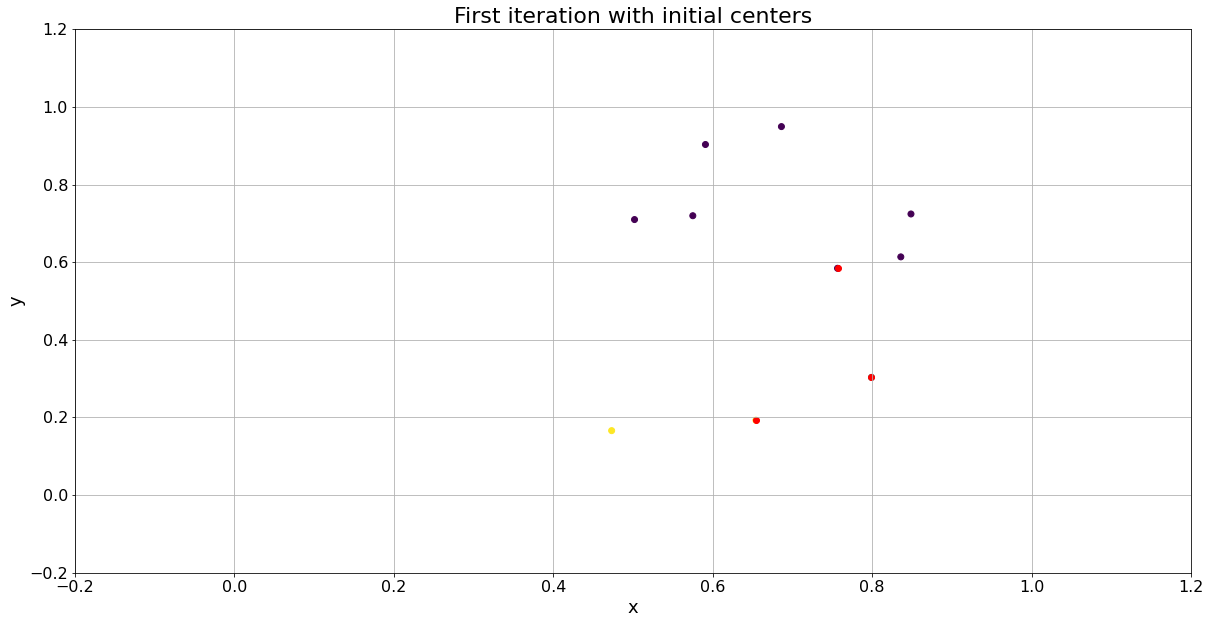

In [102]:
plt.figure(figsize = (20,10))
#plt.axes(xlim=(xlim_min, xlim_max), ylim=(ylim_min, ylim_max))
plt.title('First iteration with initial centers', fontsize = 22)
plt.xlabel('x', fontsize = 18)
plt.ylabel('y', fontsize = 18)
plt.grid(True)
plt.scatter(points[:,0], points[:,1], c = closest_points)
plt.scatter(centroids[:,0], centroids[:,1], c = 'red')
plt.xticks(np.linspace(xlim_min, xlim_max, 8), fontsize = 16)
plt.yticks(np.linspace(ylim_min, ylim_max, 8), fontsize = 16);

In [103]:
new_centroids = move_centroids(points, centroids, closest_points, k)
print(new_centroids)
print(centroids)

[[0.68510542 0.74337261]
 [0.79922241 0.30330335]
 [0.56376357 0.17956131]]
[[0.75664287 0.58424333]
 [0.79922241 0.30330335]
 [0.65425786 0.19300162]]


In [104]:
closest_points = closest_centroids(points, new_centroids, n_points, k)
print(closest_points)

[1 2 0 2 0 0 0 0 0 0]


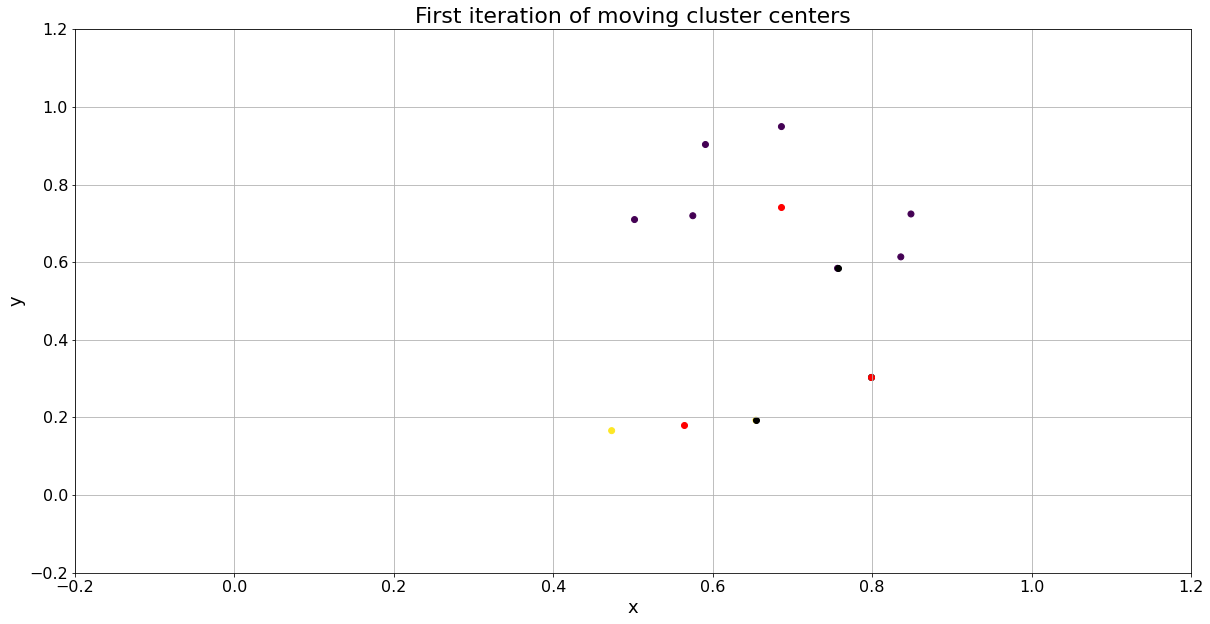

In [105]:
plt.figure(figsize = (20,10))
#plt.axes(xlim=(xlim_min, xlim_max), ylim=(ylim_min, ylim_max))
plt.title('First iteration of moving cluster centers', fontsize = 22)
plt.xlabel('x', fontsize = 18)
plt.ylabel('y', fontsize = 18)
plt.grid(True)
plt.scatter(points[:,0], points[:,1], c = closest_points)
plt.scatter(centroids[:,0], centroids[:,1], c = 'black')
plt.scatter(new_centroids[:,0], new_centroids[:,1], c = 'red')
plt.xticks(np.linspace(xlim_min, xlim_max, 8), fontsize = 16)
plt.yticks(np.linspace(ylim_min, ylim_max, 8), fontsize = 16);

In [106]:
iteration = 1
exit_condition = residual_check(new_centroids, centroids, centroids_residual)
print('Iteration number = ', iteration, end = ' ')
print(exit_condition)
while exit_condition == False:
    iteration += 1
    prev_centroids = np.copy(new_centroids)
    new_centroids = move_centroids(points, prev_centroids, closest_points, k)
    closest_points = closest_centroids(points, new_centroids, n_points, k)    
    exit_condition = residual_check(new_centroids, prev_centroids, centroids_residual)
    print('Iteration number = ', iteration, end = ' ')
    print(exit_condition)

Iteration number =  1 False
Iteration number =  2 True


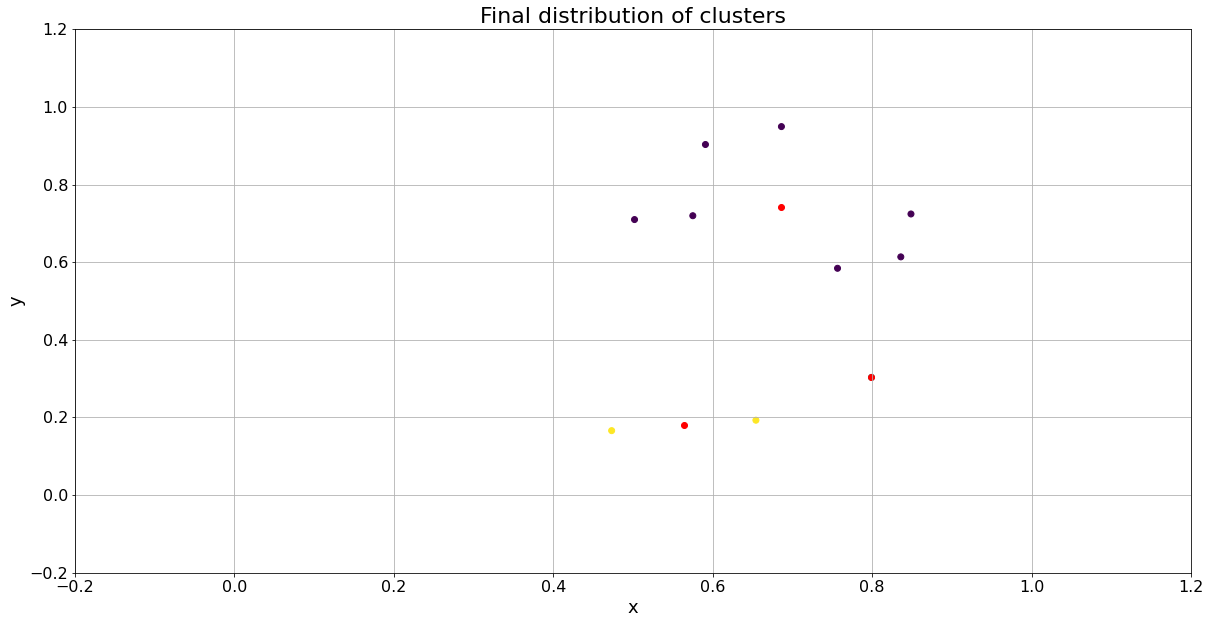

In [107]:
plt.figure(figsize = (20,10))
#plt.axes(xlim=(xlim_min, xlim_max), ylim=(ylim_min, ylim_max))
plt.title('Final distribution of clusters', fontsize = 22)
plt.xlabel('x', fontsize = 18)
plt.ylabel('y', fontsize = 18)
plt.grid(True)
plt.scatter(points[:,0], points[:,1], c = closest_points)
plt.scatter(new_centroids[:,0], new_centroids[:,1], c = 'red')
plt.xticks(np.linspace(xlim_min, xlim_max, 8), fontsize = 16)
plt.yticks(np.linspace(ylim_min, ylim_max, 8), fontsize = 16);

# Вывод.
При малом числе объектов и кластеров результат противоречит кластерной структуре множества данных. Центры кластеров лежат вне сгруппированных объектов на значительном отдалении.